In [252]:
import pandas as pd
import numpy as np
%matplotlib inline
%autosave 10
import warnings
import matplotlib.pyplot as plt

Autosaving every 10 seconds


In [272]:
df = pd.read_csv('slim_airplanes_40perc.csv')

In [273]:
if 'Unnamed: 0' in df: del df['Unnamed: 0']

In [274]:
df[df['Cancelled'] == 1].tail()

,Quarter,Month,UniqueCarrier,FlightNum,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Cancelled,CancellationCode,Distance
2123459,3,9,F9,1219,14100,13204,530,NaN,805,NaN,1.0,A,861.0
2123460,3,9,F9,1214,13204,14100,845,NaN,1110,NaN,1.0,A,861.0
2123913,3,9,F9,1271,13930,12892,2055,NaN,2323,NaN,1.0,A,1744.0
2124804,3,9,HA,44,12173,14831,1345,NaN,2155,NaN,1.0,A,2417.0
2125746,3,9,HA,162,12173,12402,1339,NaN,1430,NaN,1.0,A,216.0


In [136]:
# index = df[df['Cancelled'] == 1].groupby('DepDelay')['DepDelay'].count()
inds = pd.isnull(df).any(1).nonzero()[0]
print(inds)

[     0      1      2 ..., 531458 531459 531460]


### Identifying columns to be ignored

In [275]:
df[df['Cancelled'] == 1]['DepDelay'].isnull().sum()

31685

In [276]:
df[df['Cancelled'] == 0]['DepDelay'].isnull().sum()

0

In [277]:
df[df['Cancelled'] == 1]['ArrDelay'].isnull().sum()

31685

In [278]:
df[df['Cancelled'] == 0]['ArrDelay'].isnull().sum()

5574

In [279]:
df[df['Cancelled'] == 0]['DepDelay'].isnull().sum()

0

In [280]:
df.shape

(2125894, 13)

In [281]:
cols = ['Quarter', 'Month', 'UniqueCarrier', 'FlightNum', 'OriginAirportID', 'DestAirportID', 'Distance']

In [282]:
from sklearn import preprocessing

In [283]:
df[df['Cancelled'] == 1].head()

,Quarter,Month,UniqueCarrier,FlightNum,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,CRSArrTime,ArrDelay,Cancelled,CancellationCode,Distance
22,1,1,AA,2,12892,12478,900,NaN,1729,NaN,1.0,B,2475.0
40,1,1,AA,3,12478,12892,1230,NaN,1555,NaN,1.0,B,2475.0
50,1,1,AA,4,12892,12478,1230,NaN,2106,NaN,1.0,B,2475.0
180,1,1,AA,18,14771,12478,2225,NaN,649,NaN,1.0,B,2586.0
181,1,1,AA,18,14771,12478,2225,NaN,649,NaN,1.0,B,2586.0


In [284]:
def convert(data):
    number = preprocessing.LabelEncoder()
    data['UniqueCarrier'] = number.fit_transform(data.UniqueCarrier)
#     data['Source'] = number.fit_transform(data.Source)
    data=data.fillna(-999)
    return data

In [285]:
df.applymap(np.isreal)[cols].all(1)

0          False
1          False
2          False
3          False
4          False
5          False
6          False
7          False
8          False
9          False
10         False
11         False
12         False
13         False
14         False
15         False
16         False
17         False
18         False
19         False
20         False
21         False
22         False
23         False
24         False
25         False
26         False
27         False
28         False
29         False
           ...  
2125864    False
2125865    False
2125866    False
2125867    False
2125868    False
2125869    False
2125870    False
2125871    False
2125872    False
2125873    False
2125874    False
2125875    False
2125876    False
2125877    False
2125878    False
2125879    False
2125880    False
2125881    False
2125882    False
2125883    False
2125884    False
2125885    False
2125886    False
2125887    False
2125888    False
2125889    False
2125890    False
2125891    Fal

In [286]:
newdf = convert(df)

In [205]:
reals = newdf.applymap(np.isreal).all(1)

In [207]:
reals[reals == False].sum()

0

In [74]:
df.columns.values

array(['Quarter', 'Month', 'UniqueCarrier', 'FlightNum', 'OriginAirportID',
       'DestAirportID', 'CRSDepTime', 'DepDelay', 'CRSArrTime', 'ArrDelay',
       'Cancelled', 'CancellationCode', 'Distance'], dtype=object)

## Trying out different classifiers

In [287]:
from operator import itemgetter
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import expon as sp_expon
from time import time
from sklearn.cross_validation import train_test_split

### Split of data into train and test data

In [288]:
X_train, X_test, y_train, y_test = train_test_split(newdf[['Quarter', 'Month', 'UniqueCarrier', 'FlightNum', 'OriginAirportID', 'DestAirportID', 'Distance']], newdf['Cancelled'], test_size=0.15)

In [289]:
# Utility function to report best scores of a randomized search
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

In [290]:
X_train.shape

(1807009, 7)

In [291]:
y_train.shape

(1807009,)

In [212]:
y_train[y_train == 1].shape

(6675,)

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

In [292]:
rf = RandomForestClassifier(n_estimators=30)
param_dist = {"max_depth": [3, 10, 15, None],
              "min_samples_split": sp_randint(1, 20),
              "min_samples_leaf": sp_randint(1, 20),
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 15
rf_random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                  cv=3)

%time rf_random_search.fit(X_train, y_train)
# print("RandomizedSearchCV took %.2f seconds for %d candidates"
#       " parameter settings." % ((time() - start), n_iter_search))
report(rf_random_search.grid_scores_)

CPU times: user 51.5 s, sys: 1.13 s, total: 52.6 s
Wall time: 21min 30s
Model with rank: 1
Mean validation score: 0.985 (std: 0.000)
Parameters: {'min_samples_leaf': 10, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 11}

Model with rank: 2
Mean validation score: 0.985 (std: 0.000)
Parameters: {'min_samples_leaf': 13, 'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 11}

Model with rank: 3
Mean validation score: 0.985 (std: 0.000)
Parameters: {'min_samples_leaf': 8, 'max_depth': 15, 'criterion': 'entropy', 'min_samples_split': 9}



### Logistic Regression

In [215]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [293]:
lr = LogisticRegression()
param_dist = {'penalty' : ['l1','l2'],
             'C': sp_expon(scale=100)}
# run randomized search
n_iter_search = 25
lr_random_search = RandomizedSearchCV(lr, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                  cv=3)

start = time()
lr_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(lr_random_search.grid_scores_)

RandomizedSearchCV took 873.66 seconds for 25 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.985 (std: 0.000)
Parameters: {'C': 35.326740406565463, 'penalty': 'l1'}

Model with rank: 2
Mean validation score: 0.985 (std: 0.000)
Parameters: {'C': 84.174170218734531, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.985 (std: 0.000)
Parameters: {'C': 59.261847603066485, 'penalty': 'l2'}



In [294]:
sgd = SGDClassifier(n_iter=150)
param_dist = {'loss':['hinge', 'modified_huber'],
             'alpha':sp_expon(scale=0.2)}
# run randomized search
n_iter_search = 15
sgd_random_search = RandomizedSearchCV(sgd, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                  cv=3)

start = time()
sgd_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(sgd_random_search.grid_scores_)

RandomizedSearchCV took 521.30 seconds for 15 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.985 (std: 0.000)
Parameters: {'loss': 'hinge', 'alpha': 0.010575634066853872}

Model with rank: 2
Mean validation score: 0.985 (std: 0.000)
Parameters: {'loss': 'hinge', 'alpha': 0.10371147318548973}

Model with rank: 3
Mean validation score: 0.985 (std: 0.000)
Parameters: {'loss': 'modified_huber', 'alpha': 0.12125197548684599}



### Naive Bayes

In [295]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB

In [296]:
mnb = MultinomialNB()
param_dist = {'alpha':sp_expon(scale=10)}
# run randomized search
n_iter_search = 35
mnb_random_search = RandomizedSearchCV(mnb, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                  cv=3)

start = time()
mnb_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(mnb_random_search.grid_scores_)

RandomizedSearchCV took 133.34 seconds for 35 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.641 (std: 0.000)
Parameters: {'alpha': 6.4439016716450306}

Model with rank: 2
Mean validation score: 0.641 (std: 0.000)
Parameters: {'alpha': 2.8638425330994393}

Model with rank: 3
Mean validation score: 0.641 (std: 0.000)
Parameters: {'alpha': 6.240873068786196}



In [297]:
bnb = BernoulliNB()
param_dist = {'alpha':sp_expon(scale=0.3),
              'binarize': sp_expon(scale=2)
             }
# run randomized search
n_iter_search = 35
bnb_random_search = RandomizedSearchCV(bnb, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1,
                                  cv=3)

start = time()
bnb_random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(bnb_random_search.grid_scores_)

RandomizedSearchCV took 139.23 seconds for 35 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.985 (std: 0.000)
Parameters: {'binarize': 4.2232983537336288, 'alpha': 0.085068325046037355}

Model with rank: 2
Mean validation score: 0.985 (std: 0.000)
Parameters: {'binarize': 1.2932873145627168, 'alpha': 0.095935356319031176}

Model with rank: 3
Mean validation score: 0.985 (std: 0.000)
Parameters: {'binarize': 1.2667800521091885, 'alpha': 0.3119314253113914}



In [298]:
from sklearn.neighbors import KNeighborsClassifier

In [299]:
knn = KNeighborsClassifier()

param_dist = {'n_neighbors': [5, 10, 15, 20, 25, 30], 'weights': ['uniform', 'distance']}

n_iter_search = 12
knn_random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=n_iter_search, n_jobs=-1, cv=3)

knn_random_search.fit(X_train, y_train)
report(knn_random_search.grid_scores_)

Model with rank: 1
Mean validation score: 0.985 (std: 0.000)
Parameters: {'weights': 'uniform', 'n_neighbors': 20}

Model with rank: 2
Mean validation score: 0.985 (std: 0.000)
Parameters: {'weights': 'uniform', 'n_neighbors': 25}

Model with rank: 3
Mean validation score: 0.985 (std: 0.000)
Parameters: {'weights': 'uniform', 'n_neighbors': 30}



### Ensemble of classifiers

In [300]:
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import cross_val_score

In [301]:
ensemble3 = VotingClassifier(estimators=[('lr',lr_random_search.best_estimator_),\
                                        ('rf', rf_random_search.best_estimator_),\
                                        ('bnb', bnb_random_search.best_estimator_)],
                            voting='soft')
scores = cross_val_score(ensemble3, X_train, y_train, cv=5)
print ('%f (std: %f)' % (scores.mean(), scores.std()))
ensemble3.fit(X_train, y_train)

0.985117 (std: 0.000001)


VotingClassifier(estimators=[('lr', LogisticRegression(C=35.326740406565463, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)),...B(alpha=0.085068325046037355, binarize=4.2232983537336288,
      class_prior=None, fit_prior=True))],
         voting='soft', weights=None)

In [302]:
from sklearn.metrics import accuracy_score, f1_score

In [303]:
models = {'random forest' : rf_random_search, 
          'logistic regression' : lr_random_search, 
          'sgd svm' : sgd_random_search, 
          'multinomial naive bayes' : mnb_random_search, 
          'bernoulli' : bnb_random_search,
          'knn': knn_random_search,
          'ensemble' : ensemble3}
results = {k:{} for k in models.keys()}
for model in models:
    m = models[model]
    predicted = m.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    f1 = f1_score(y_test, predicted)
    results[model]['accuracy'] = acc
    results[model]['f1'] = f1
    print ('%s, accuracy: %f f1: %f' % (model, acc, f1))

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


knn, accuracy: 0.984973 f1: 0.000000
bernoulli, accuracy: 0.984973 f1: 0.000000
multinomial naive bayes, accuracy: 0.640541 f1: 0.044847
ensemble, accuracy: 0.984973 f1: 0.000000
logistic regression, accuracy: 0.984973 f1: 0.000000
sgd svm, accuracy: 0.984810 f1: 0.000825
random forest, accuracy: 0.984973 f1: 0.000000


In [304]:
import seaborn as sns

In [305]:
clfs = {'model': pd.Series([m for m in results.keys()], index=np.arange(len(results))),
       'accuracy': pd.Series([results[m]['accuracy'] for m in results.keys()], index=np.arange(len(results))),
       'f1': pd.Series([results[m]['f1'] for m in results.keys()], index=np.arange(len(results)))}
clfs_df = pd.DataFrame(clfs)

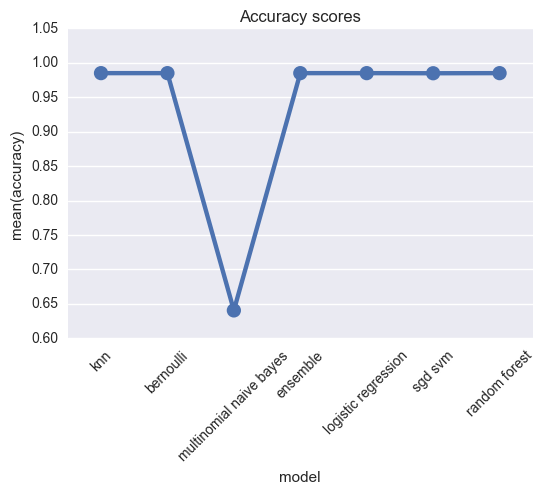

In [313]:
sns.pointplot(x='model', y='accuracy', data=clfs_df)
plt.xticks(rotation=45)
plt.title('Accuracy scores')
plt.savefig('graph/acc_scores_classifiers.png', bbox_inches='tight')

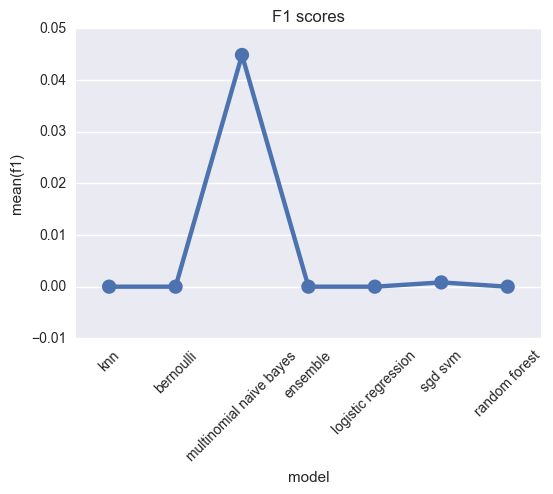

In [314]:
sns.pointplot(x='model', y='f1', data=clfs_df)
plt.xticks(rotation=45)
plt.title('F1 scores')
plt.savefig('graph/f1_scores_classifiers.png', bbox_inches='tight')

In [309]:
# serializing model

from sklearn.externals import joblib
joblib.dump(lr_random_search.best_estimator_, 'pickle/lr/lr.pkl')
joblib.dump(rf_random_search.best_estimator_, 'pickle/rf/rf.pkl')
joblib.dump(bnb_random_search.best_estimator_, 'pickle/bnb/bnb.pkl')
joblib.dump(sgd_random_search.best_estimator_, 'pickle/sgd/sgd.pkl')
joblib.dump(mnb_random_search.best_estimator_, 'pickle/mnb/mnb.pkl')
joblib.dump(knn_random_search.best_estimator_, 'pickle/knn/knn.pkl')
joblib.dump(ensemble3, 'pickle/ensemble/ensemble.pkl')

['pickle/ensemble/ensemble.pkl',
 'pickle/ensemble/ensemble.pkl_01.npy',
 'pickle/ensemble/ensemble.pkl_02.npy',
 'pickle/ensemble/ensemble.pkl_03.npy',
 'pickle/ensemble/ensemble.pkl_04.npy',
 'pickle/ensemble/ensemble.pkl_05.npy',
 'pickle/ensemble/ensemble.pkl_06.npy',
 'pickle/ensemble/ensemble.pkl_07.npy',
 'pickle/ensemble/ensemble.pkl_08.npy',
 'pickle/ensemble/ensemble.pkl_09.npy',
 'pickle/ensemble/ensemble.pkl_10.npy',
 'pickle/ensemble/ensemble.pkl_11.npy',
 'pickle/ensemble/ensemble.pkl_12.npy',
 'pickle/ensemble/ensemble.pkl_13.npy',
 'pickle/ensemble/ensemble.pkl_14.npy',
 'pickle/ensemble/ensemble.pkl_15.npy',
 'pickle/ensemble/ensemble.pkl_16.npy',
 'pickle/ensemble/ensemble.pkl_17.npy',
 'pickle/ensemble/ensemble.pkl_18.npy',
 'pickle/ensemble/ensemble.pkl_19.npy',
 'pickle/ensemble/ensemble.pkl_20.npy',
 'pickle/ensemble/ensemble.pkl_21.npy',
 'pickle/ensemble/ensemble.pkl_22.npy',
 'pickle/ensemble/ensemble.pkl_23.npy',
 'pickle/ensemble/ensemble.pkl_24.npy',
 'pickl